# Imports

In [1]:
import plotly.io as pio
import plotly.offline as pyo
import plotly.express as px
pyo.init_notebook_mode()
import torch
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from functools import partial
from jaxtyping import Float
from tqdm.notebook import tqdm

# if plotly isn't working, i did
# install nvm from
# https://github.com/nvm-sh/nvm
# and activate it
# then i did
# nvm install node
# jupyter labextension install plotlywidget

# modified neel nanda's examples
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    fig = px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs)
     # default settings aren't very good, these are better
    plot_args = {
        'width': 800,
        'height': 600,
        "autosize": False,
        'showlegend': True,
        'margin': {"l":0,"r":0,"t":100,"b":0}
    }
    fig.update_layout(**plot_args)
    fig.update_layout(legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ))
    fig.show(renderer)

# Load Mamba

In [2]:
from mamba_lens import HookedMamba
torch.set_grad_enabled(False)
device = utils.get_device()
model = HookedMamba.from_pretrained("state-spaces/mamba-370m", device=device)

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning:

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Moving model to device:  cuda


# h similarities

In [33]:
prompt = "Then, Shelby and Jerry had a lot of fun at the restaurant. Shelby gave a ring to"
# different names act different, idk why
#prompt = 'Then, Shelby and Emma had a lot of fun at the school. Shelby gave an apple to'

adjust LAYERS variable to choose a different layer
context len 20


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

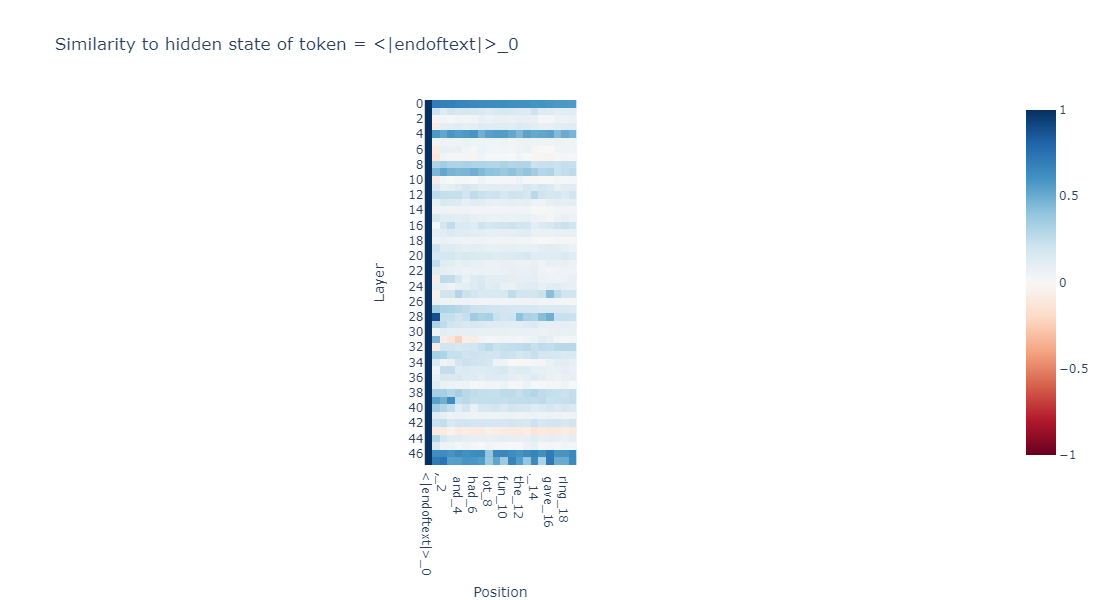

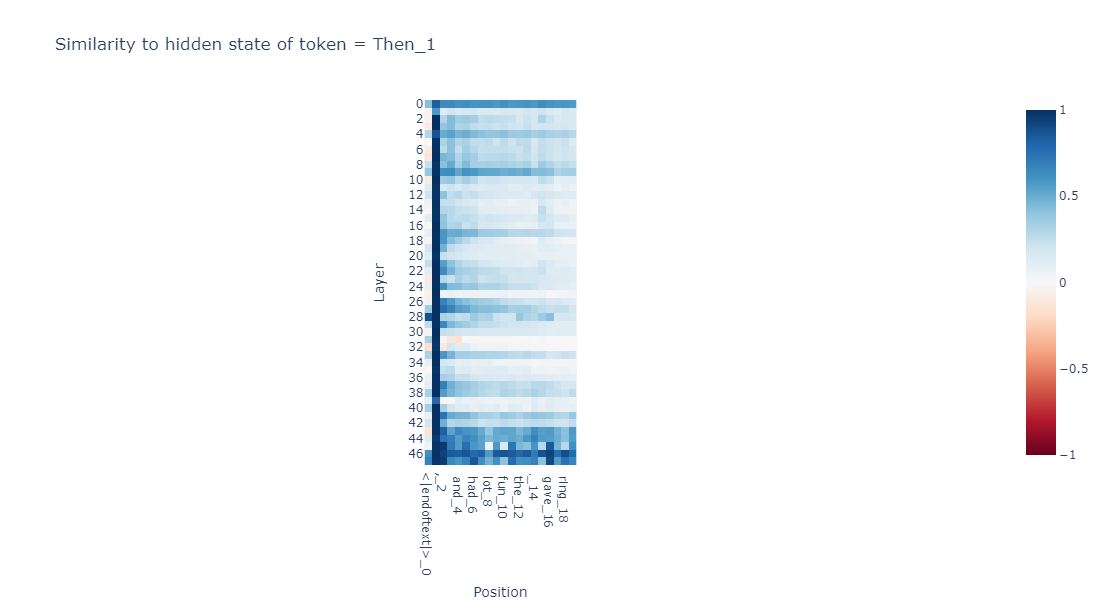

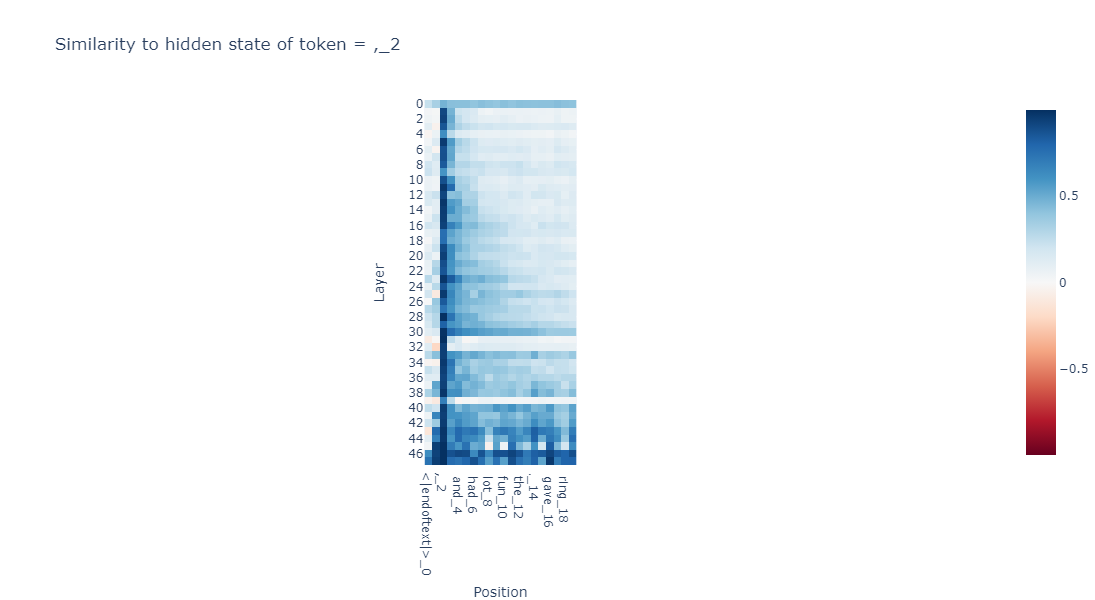

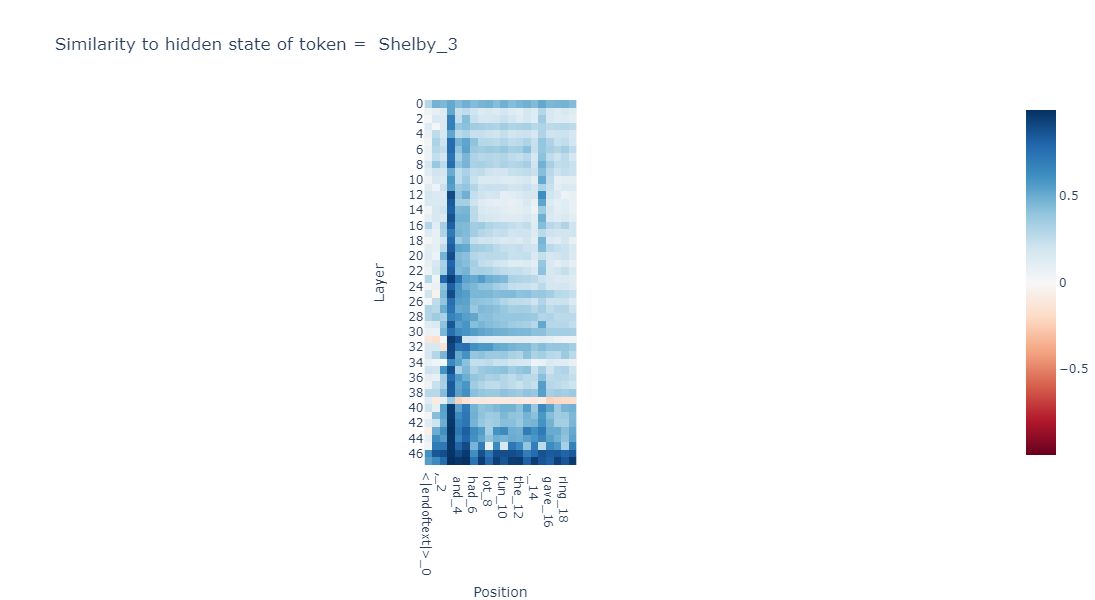

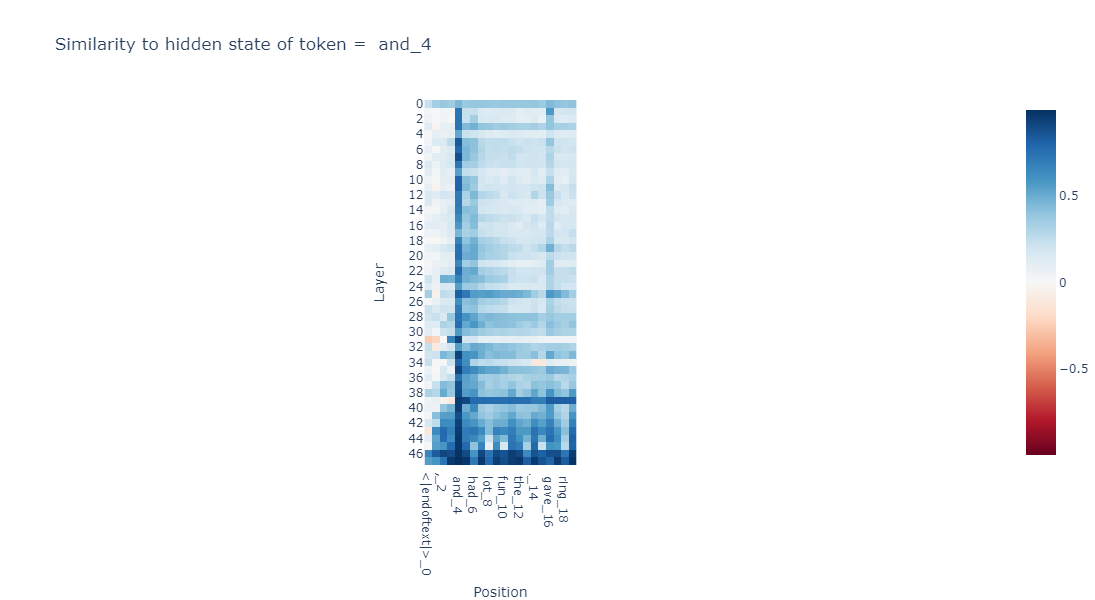

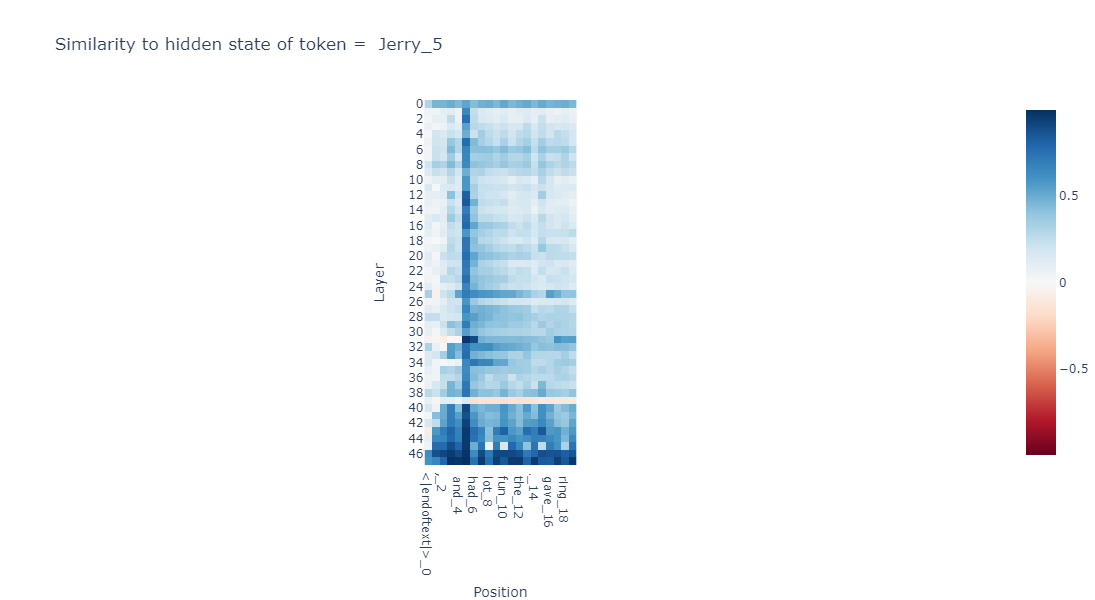

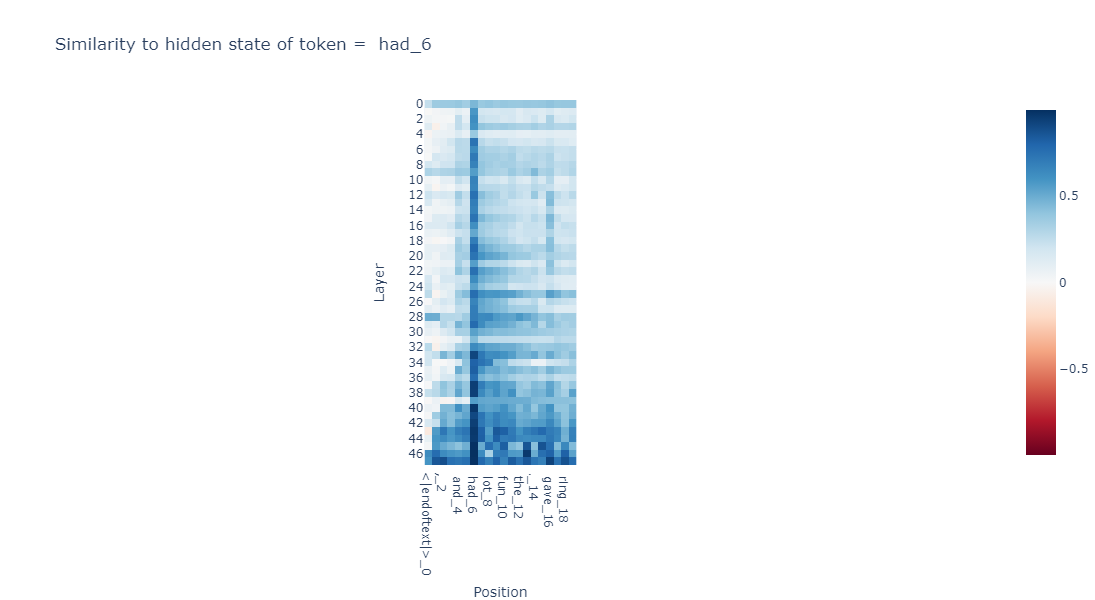

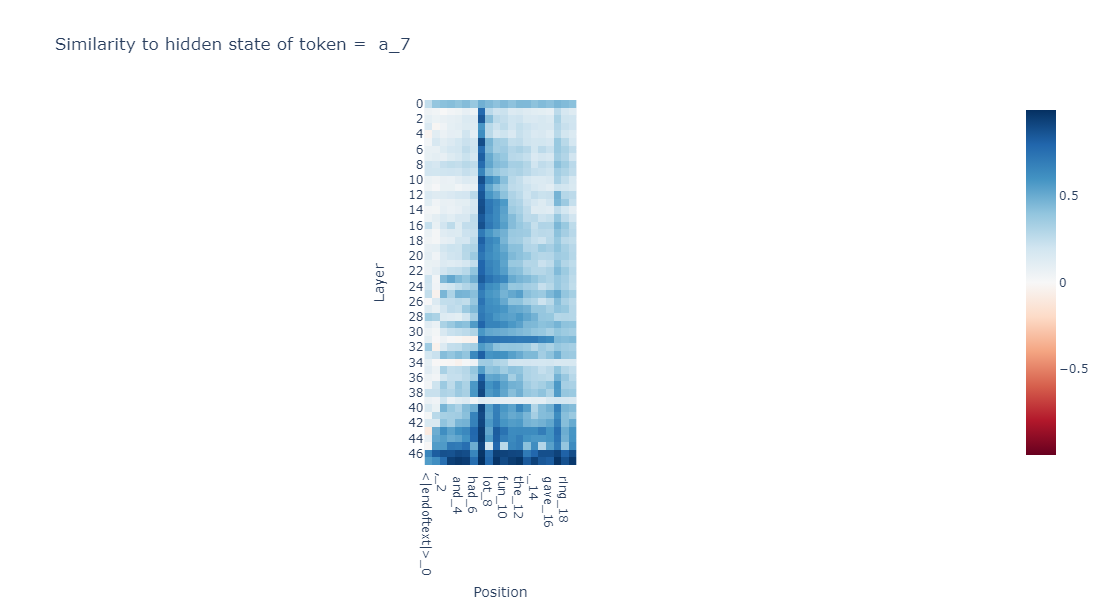

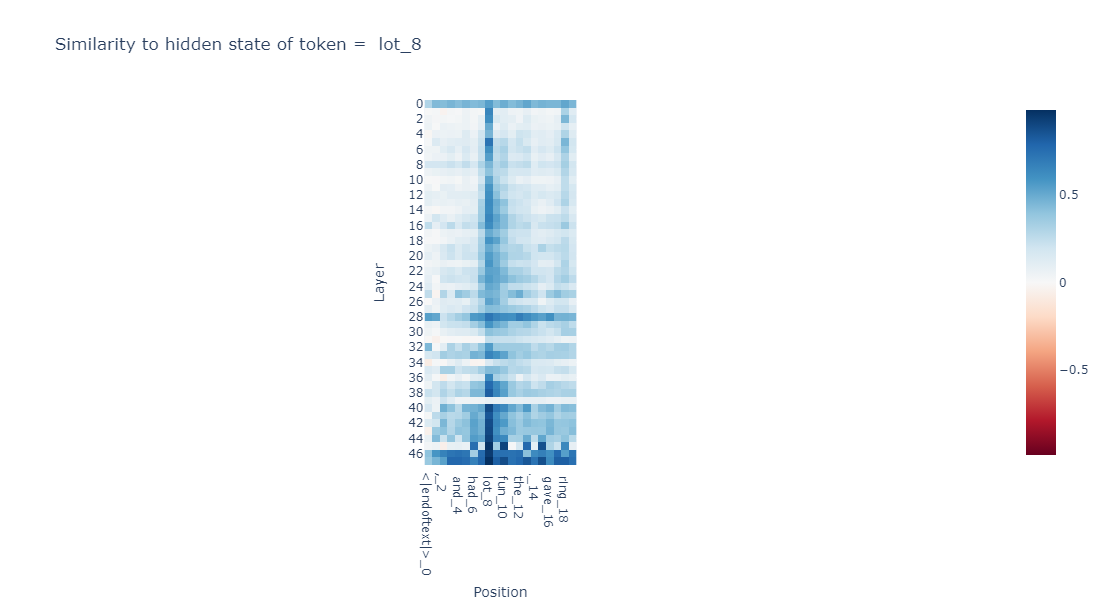

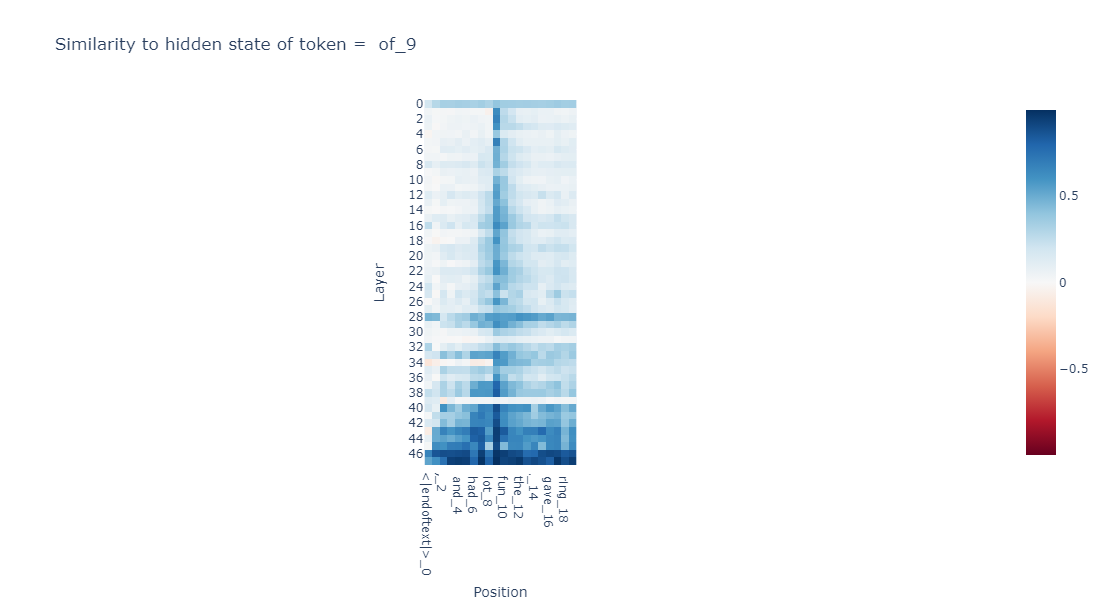

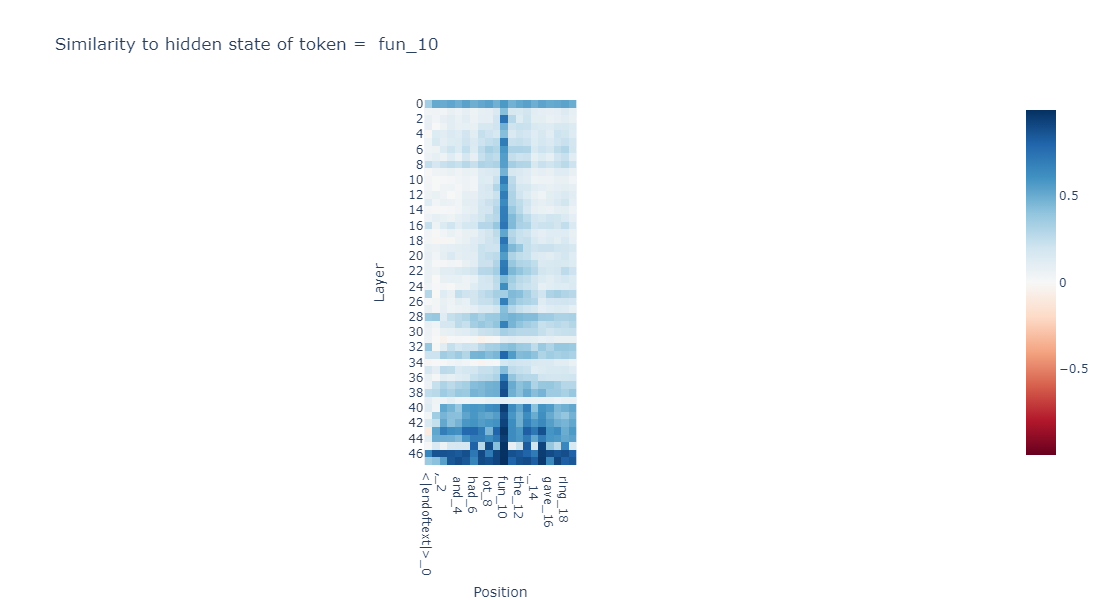

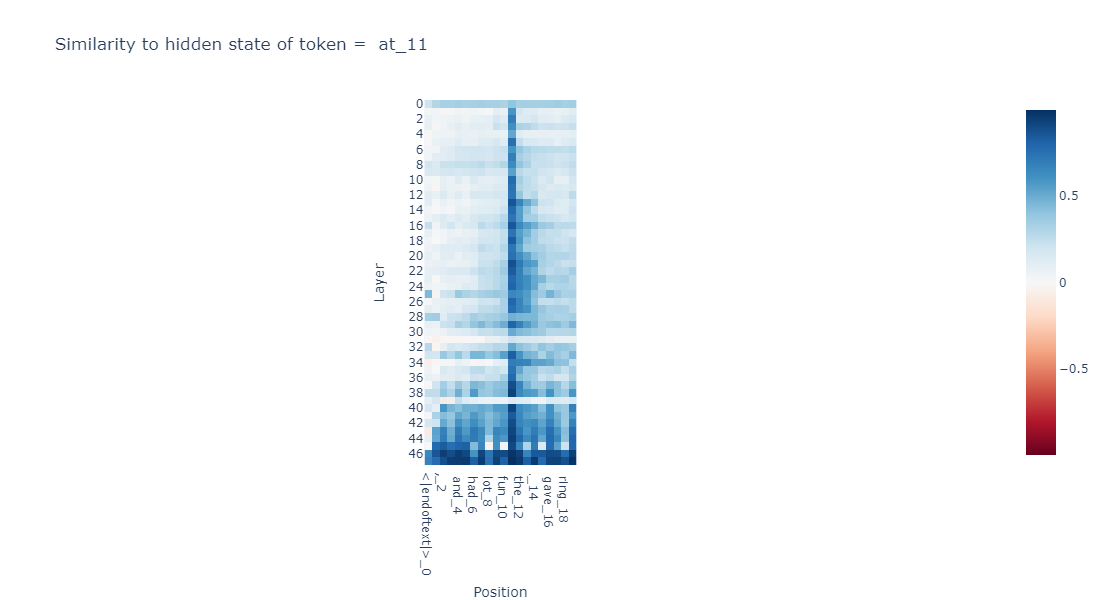

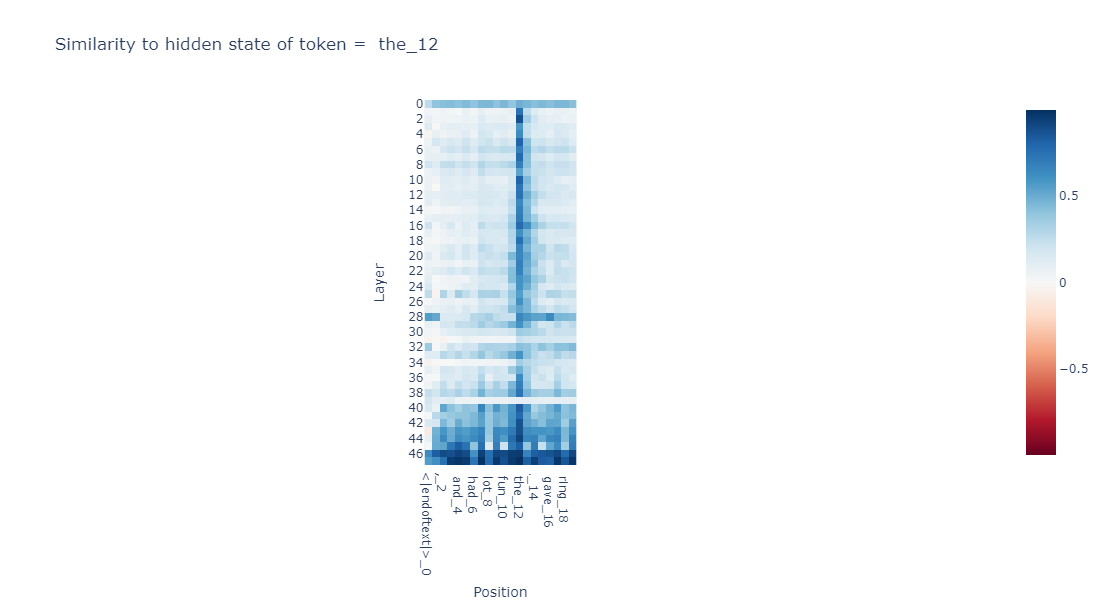

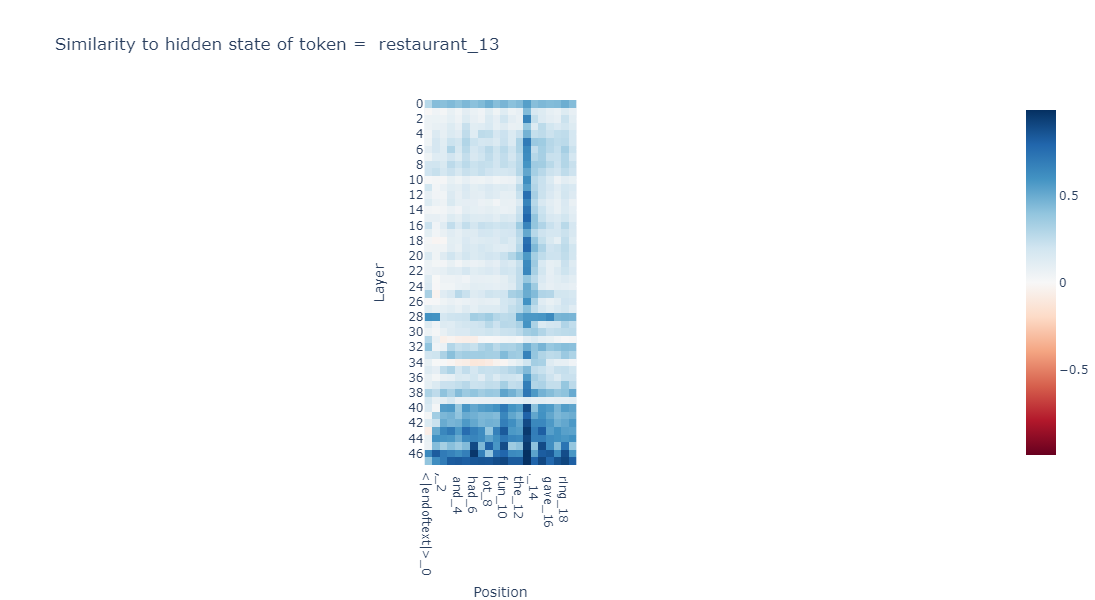

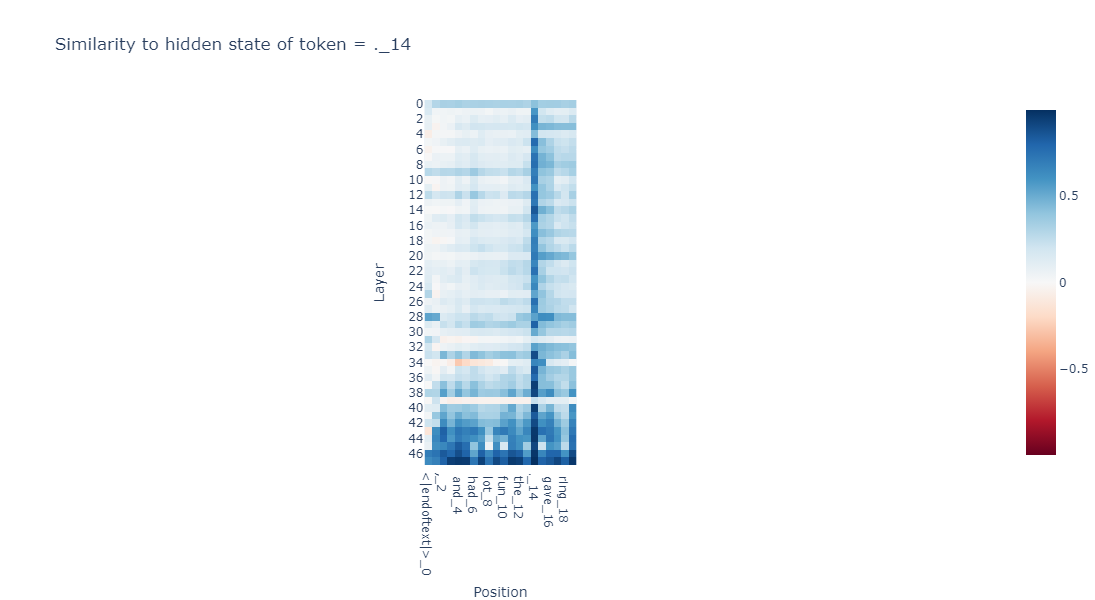

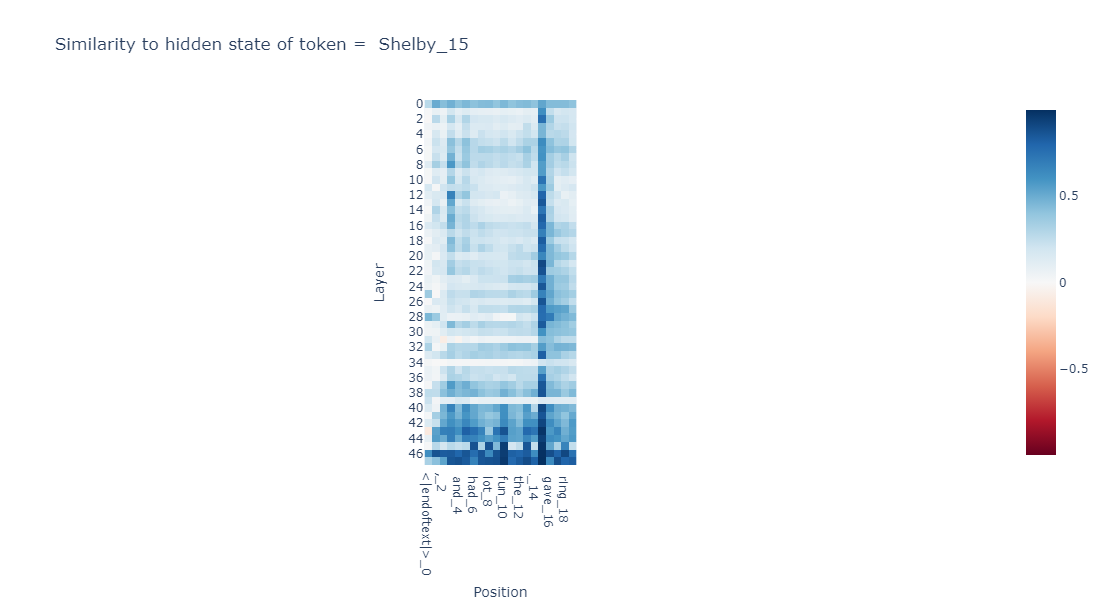

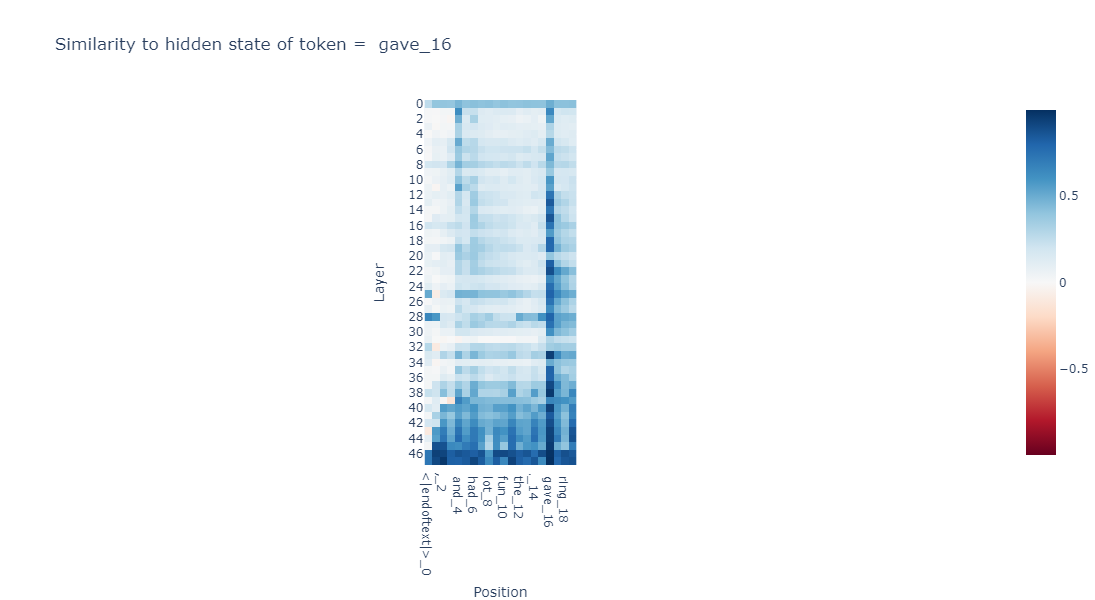

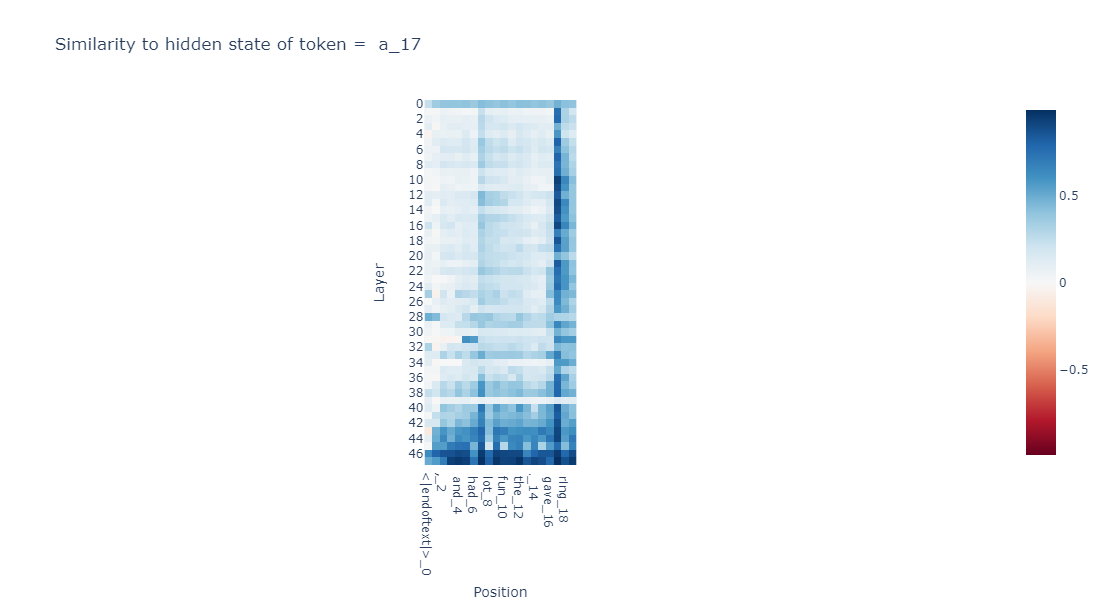

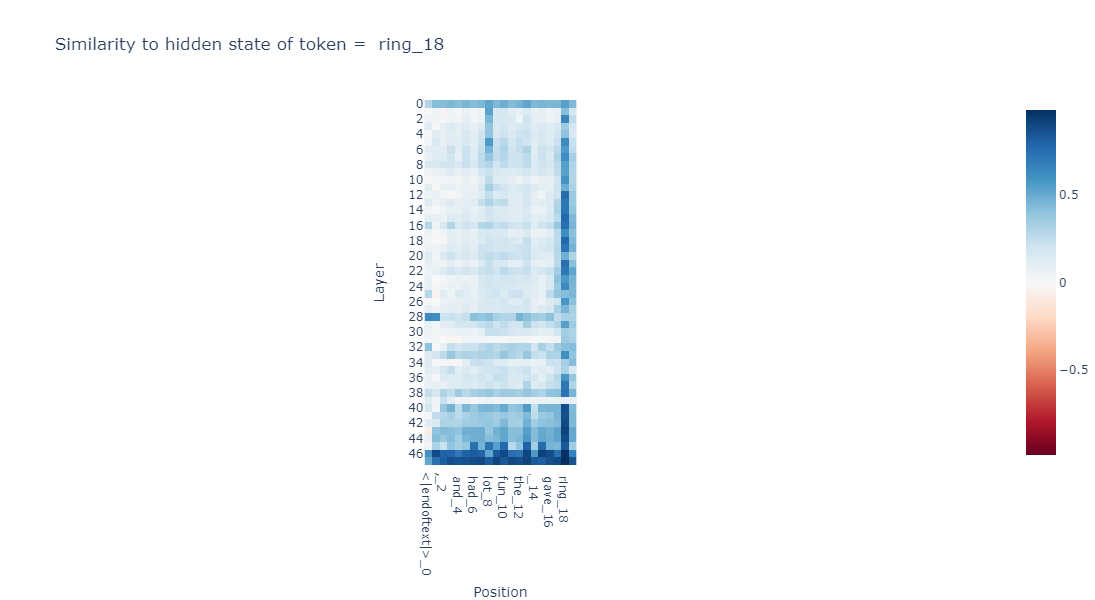

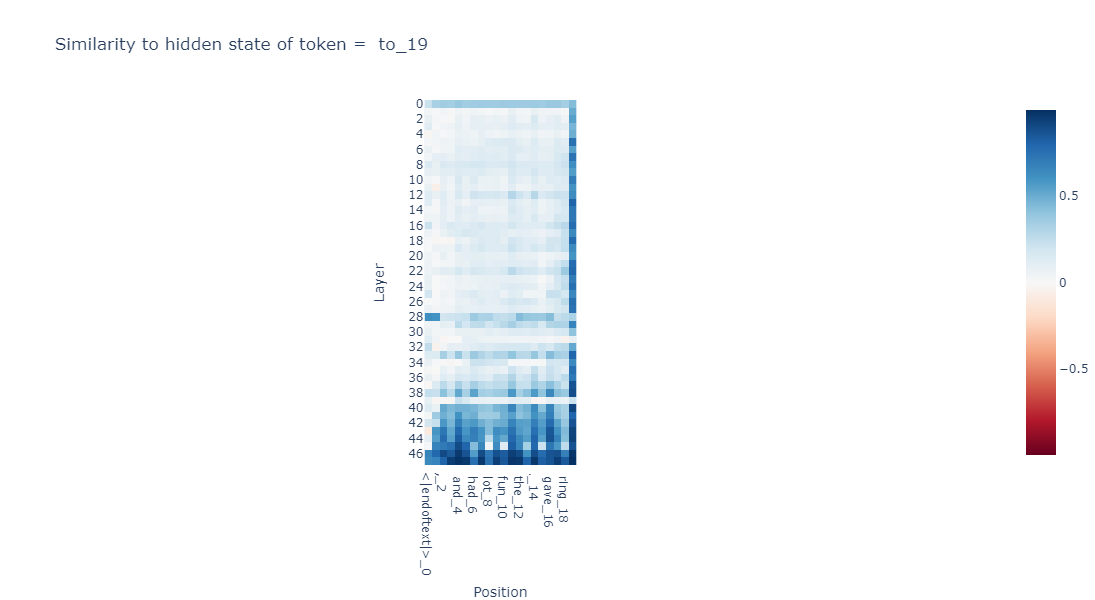

In [39]:
print("adjust LAYERS variable to choose a different layer")
LAYERS = [39]
# uncomment this to plot over all layers
#LAYERS = list(range(model.cfg.n_layers))

def cosine_similarity(vec1, vec2):
    B = vec1.size()[0]
    vec1 = vec1.reshape(B,-1)
    vec2 = vec2.reshape(B,-1)
    my_mag = torch.linalg.norm(vec1, ord=2, dim=1)
    my_mag[my_mag == 0] = 1.0 # prevent divide by zero
    other_mag = torch.linalg.norm(vec2, ord=2, dim=1)
    other_mag[other_mag == 0] = 1.0 # prevent divide by zero
    prod = vec1 * vec2
    dot_prod = prod.sum(dim=1)
    sims = dot_prod * (1.0/my_mag) * (1.0/other_mag)
    return torch.mean(sims, dim=0)


prompt_tokens = model.to_tokens(prompt)
B,L = prompt_tokens.size()
print(f"context len {L}")
n_layers = len(LAYERS)
names_filter = []
for layer in LAYERS:
    names_filter.append(f'blocks.{layer}.hook_A_bar')
    names_filter.append(f'blocks.{layer}.hook_B_bar')
    names_filter.append(f'blocks.{layer}.hook_ssm_input')
    for l in range(L):
        names_filter.append(f'blocks.{layer}.hook_h.{l}')
        
logits, activations = model.run_with_cache(prompt_tokens, names_filter=names_filter)

h_similarities = torch.zeros([n_layers, L, L])
x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities = torch.zeros([n_layers, L, L])
h_to_x_b_similarities_catchup = torch.zeros([n_layers, L, L])
E,N = model.cfg.E, model.cfg.N
layers_iter = list(enumerate(LAYERS))
if len(LAYERS) > 3:
    layers_iter = tqdm(layers_iter)
for i, layer in layers_iter:
    # [B,L,E,N]
    A_bar = activations[f'blocks.{layer}.hook_A_bar']
    # [B,L,E,N]
    B_bar = activations[f'blocks.{layer}.hook_B_bar']
    # [B,L,E]
    x = activations[f'blocks.{layer}.hook_ssm_input']
    # [B,L,E,N]
    x_b = x.view(B,L,E,1)*B_bar
    for pos in range(L):
        my_h = activations[f'blocks.{layer}.hook_h.{pos}']
        my_x_b = x_b[:,pos,:,:]
        for other_pos in range(L):
            other_h = activations[f'blocks.{layer}.hook_h.{other_pos}']
            other_x_b = x_b[:,other_pos,:,:]
            h_similarities[i,pos,other_pos] = cosine_similarity(my_h, other_h)
            x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_x_b)
            h_to_x_b_similarities[i,pos,other_pos] = cosine_similarity(my_x_b, other_h)
            my_x_b_catchuped = my_x_b
            # multiply by A_bar the number of times needed to catchup
            for catchup_pos in range(pos+1, other_pos+1):
                my_x_b_catchuped = my_x_b_catchuped * A_bar[:,catchup_pos]
            h_to_x_b_similarities_catchup[i,pos,other_pos] = cosine_similarity(my_x_b_catchuped, other_h)
# cleanup
del activations
del logits
torch.cuda.empty_cache()

prompt_str_tokens = model.to_str_tokens(prompt_tokens)

token_labels = []
for index, str_token in enumerate(prompt_str_tokens):
    token_labels.append(f"{str_token}_{index}")

# for each pos

if len(LAYERS) >= 3:
    layer_labels = [str(layer) for layer in LAYERS]
    for pos in list(range(L)):
        imshow(h_to_x_b_similarities[:,pos], x=token_labels, y=layer_labels, xaxis="Position", yaxis="Layer", title=f"Similarity to hidden state of token = {token_labels[pos]}")
       

if len(LAYERS) < 3: # don't spam, feel free to remove this
    for i, layer in enumerate(LAYERS):
        imshow(x_b_similarities[i], x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to B x_j on layer {LAYER}")
        imshow(h_similarities[i], x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of h_i to h_j on layer {LAYER}")
        imshow(h_to_x_b_similarities[i], x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of B x_i to h_j on layer {LAYER}")
        imshow(h_to_x_b_similarities_catchup[i], x=token_labels, y=token_labels, xaxis="Position", yaxis="Position", title=f"Similarity of A_bar^(...) B x_i to h_j on layer {LAYER}")
